# THIS FILE CONTAINS FIRST ITERATION OF EXPLORATION OF POTENTIAL VARIABLES AND MODEL 

## W O R K I N P R O G R E S S . . . .

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE

In [4]:
data = pd.read_csv('../Data/train.csv')
test_data = pd.read_csv('../Data/test.csv')

# Feature engineering
    - Handle categorial 'parentspecies'
    - Combine and summarize atom information
    - Im not sure about the usefullness of these and they were suggested from GenAI
    - However we will see if there is any benefits as we do the feature selection

In [ ]:
# Feature Engineering function // Note this is just experimental with no real subject knowledge
def feature_engineering(data):
    data['C_per_Atom'] = data['NumOfC'] / data['NumOfAtoms']
    data['O_per_Atom'] = data['NumOfO'] / data['NumOfAtoms']
    data['H_C_Ratio'] = (data['NumOfAtoms'] - (data['NumOfC'] + data['NumOfO'] + data['NumOfN'])) / data['NumOfC']
    data['Polar_NonPolar_Ratio'] = (data['NumHBondDonors'] + data['aromatic hydroxyl'] + data['aldehyde']) / data['NumOfC']

    data['O_balance'] = (data['NumOfO'] - data['NumOfC']) / data['NumOfAtoms']
    data['carbonyl_group_count'] = (data['aldehyde'] + data['ketone'] + data['carboxylic acid'] + data['ester'])
    data['stability_score'] = data['NumOfConfUsed'] / data['NumOfConf']
    return data

def categorial_to_dummy(data):
    data = pd.get_dummies(data, columns=['parentspecies'], drop_first=True)
    return data

# Scaling
    - Probably not needed but should not harm anyone to scale the continuos and new vars based on those

In [29]:
# Scaling function
def scaling(data):
    scaler = StandardScaler()
    scaled_columns = [
        'MW', 'NumOfAtoms', 'NumOfC', 'NumOfO', 'NumOfN', 'NumHBondDonors',
        'C_per_Atom', 'O_per_Atom', 'H_C_Ratio', 'Polar_NonPolar_Ratio',
        'O_balance', 'carbonyl_group_count', 'stability_score'
    ]
    data[scaled_columns] = scaler.fit_transform(data[scaled_columns])
    return data

# Correlation

In [ ]:
# Corr absoulte values
correlations = data.corr().abs()['log_pSat_Pa'].sort_values(ascending=False)
print(correlations)

log_pSat_Pa                          1.000000
NumHBondDonors                       0.689196
stability_score                      0.593965
NumOfConf                            0.513653
Polar_NonPolar_Ratio                 0.382842
hydroperoxide                        0.314053
hydroxyl (alkyl)                     0.310452
NumOfAtoms                           0.307337
carboxylic acid                      0.304259
NumOfC                               0.262769
H_C_Ratio                            0.226820
carbonylperoxynitrate                0.223739
MW                                   0.199574
NumOfN                               0.183152
ketone                               0.164555
NumOfO                               0.155064
carbonylperoxyacid                   0.114080
O_per_Atom                           0.090945
ester                                0.069376
C_per_Atom                           0.062793
O_balance                            0.056802
parentspecies_apin_decane         

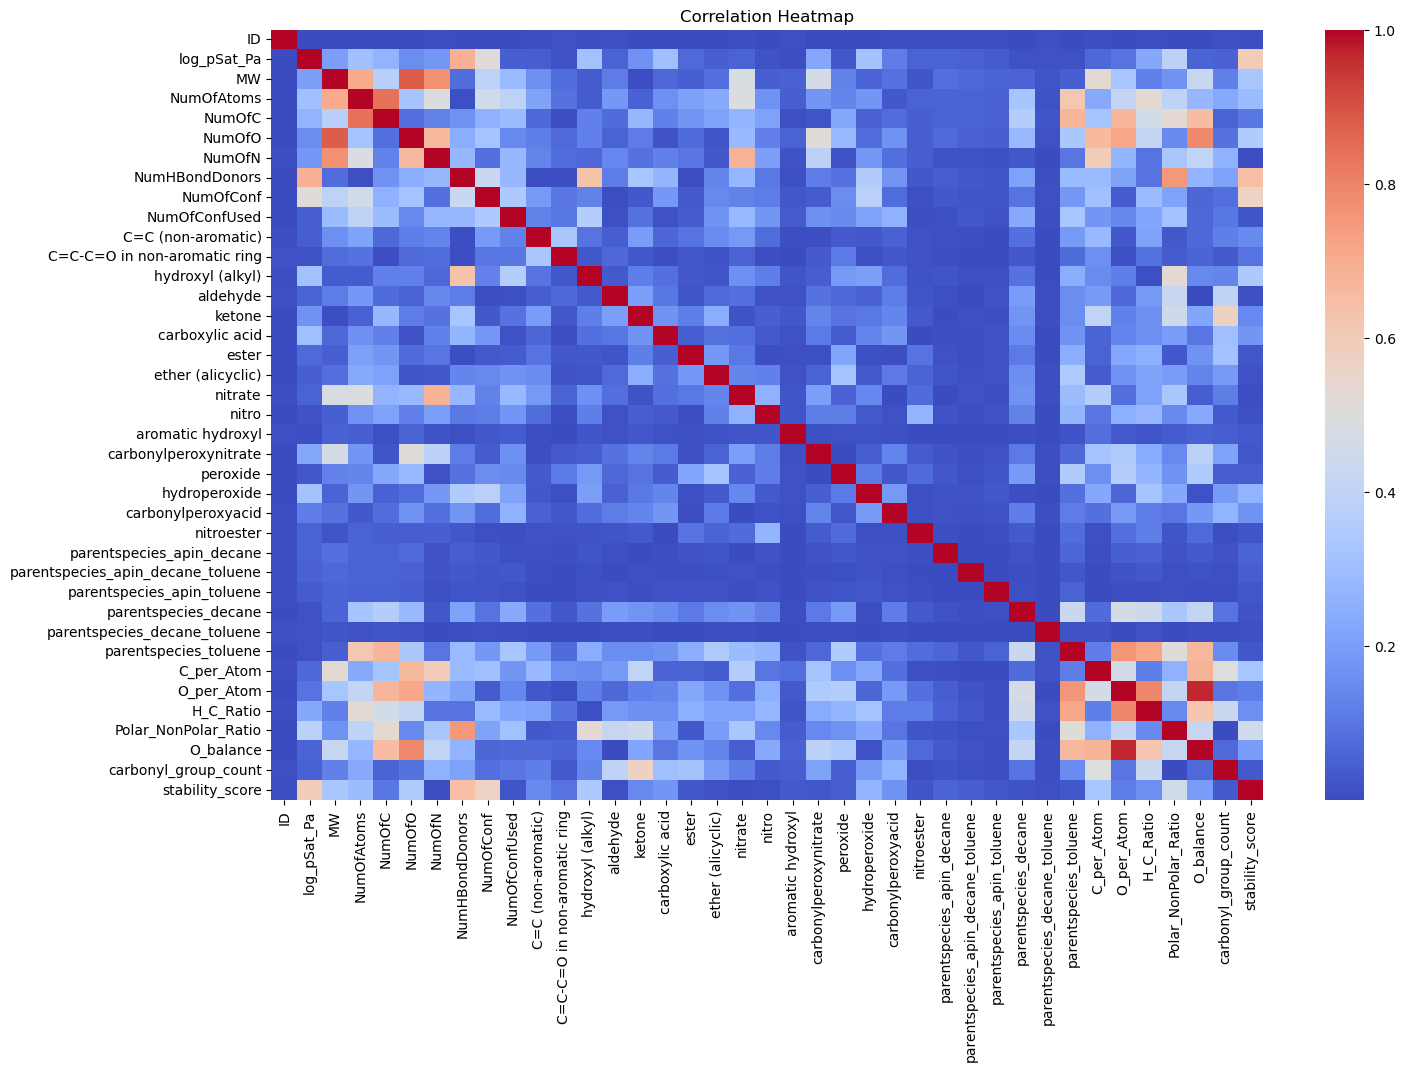

In [14]:
# corr viz
plt.figure(figsize=(16, 10))
sns.heatmap(data.corr().abs(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Feature selection 

### Lasso and some other could be also tested here

### - Now : Mutual info, RF and RFE

In [34]:
# Mutual Info scores of features / feature selection
X = data.drop(columns=['log_pSat_Pa', 'ID'])
y = data['log_pSat_Pa']

mutual_info = mutual_info_regression(X, y)
mutual_info = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)
print("\nMutual Information Scores:\n", mutual_info)



Mutual Information Scores:
 NumHBondDonors                       0.334537
stability_score                      0.288696
Polar_NonPolar_Ratio                 0.252635
NumOfConf                            0.217896
MW                                   0.165311
H_C_Ratio                            0.109780
O_per_Atom                           0.092099
NumOfAtoms                           0.088924
O_balance                            0.084936
NumOfC                               0.073930
C_per_Atom                           0.069465
hydroperoxide                        0.055396
NumOfConfUsed                        0.054503
hydroxyl (alkyl)                     0.054044
carboxylic acid                      0.053930
NumOfO                               0.049143
carbonylperoxynitrate                0.028360
NumOfN                               0.026990
ketone                               0.016453
nitrate                              0.012245
carbonyl_group_count                 0.007574
paren

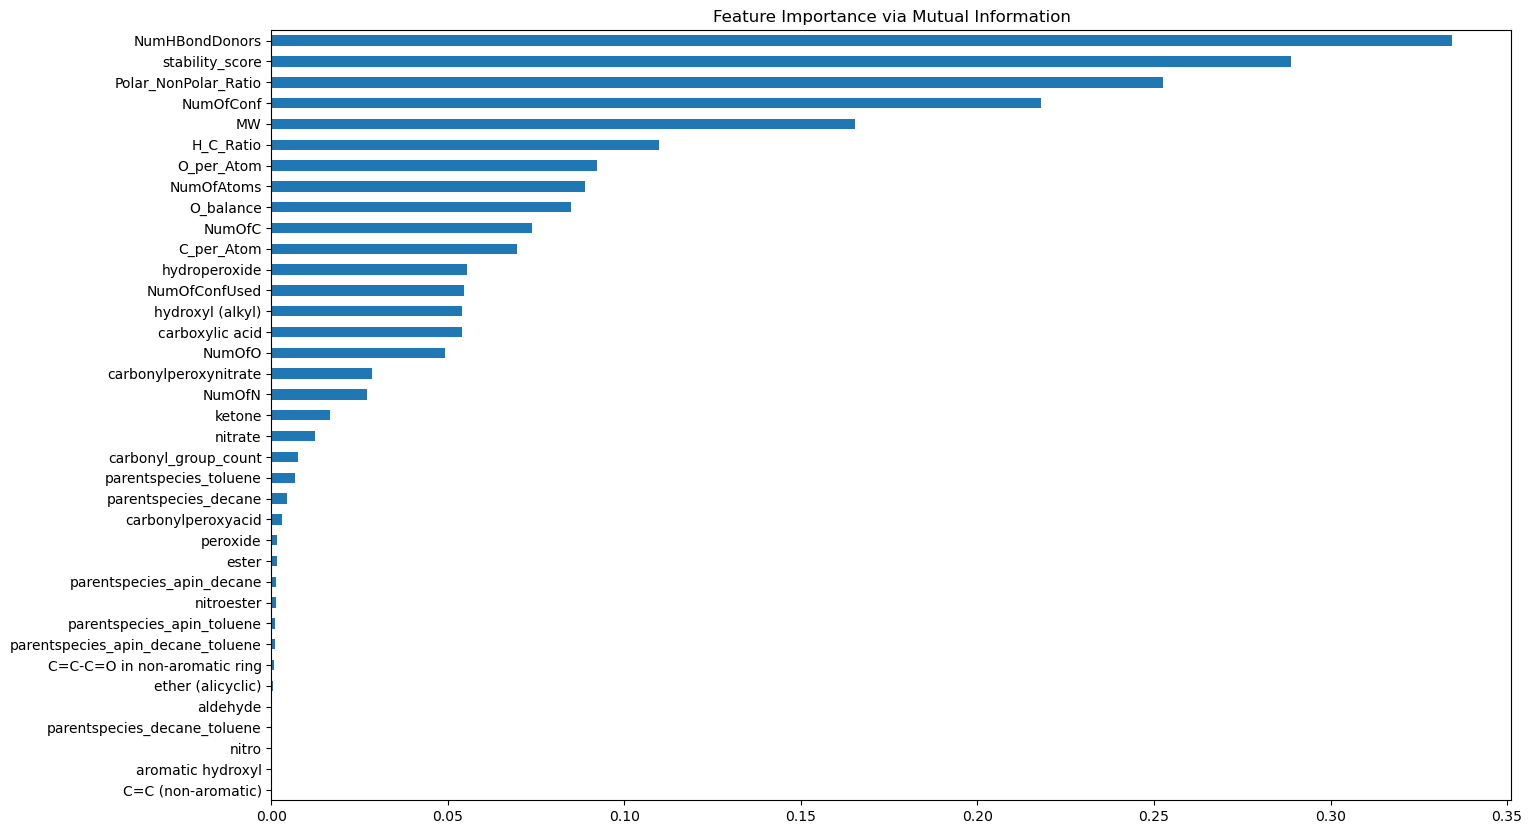

In [36]:
# importancy viz via mutual info
plt.figure(figsize=(16, 10))
mutual_info.sort_values(ascending=True).plot.barh()
plt.title("Feature Importance via Mutual Information")
plt.show()


In [37]:
# Automatic feature selection
model = RandomForestRegressor(n_estimators=100, random_state=15)
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nRandom Forest Feature Importances:\n", feature_importances)


Random Forest Feature Importances:
 NumHBondDonors                       4.148139e-01
stability_score                      1.614652e-01
NumOfC                               1.066037e-01
NumOfConf                            7.070728e-02
NumOfConfUsed                        2.929393e-02
hydroxyl (alkyl)                     1.842427e-02
carbonylperoxynitrate                1.809157e-02
O_per_Atom                           1.525352e-02
carboxylic acid                      1.512169e-02
O_balance                            1.343114e-02
MW                                   1.283290e-02
ketone                               1.228586e-02
NumOfAtoms                           1.152898e-02
H_C_Ratio                            1.143997e-02
C_per_Atom                           1.118266e-02
carbonyl_group_count                 1.035908e-02
peroxide                             7.904147e-03
Polar_NonPolar_Ratio                 7.102017e-03
hydroperoxide                        6.747776e-03
C=C (non-arom

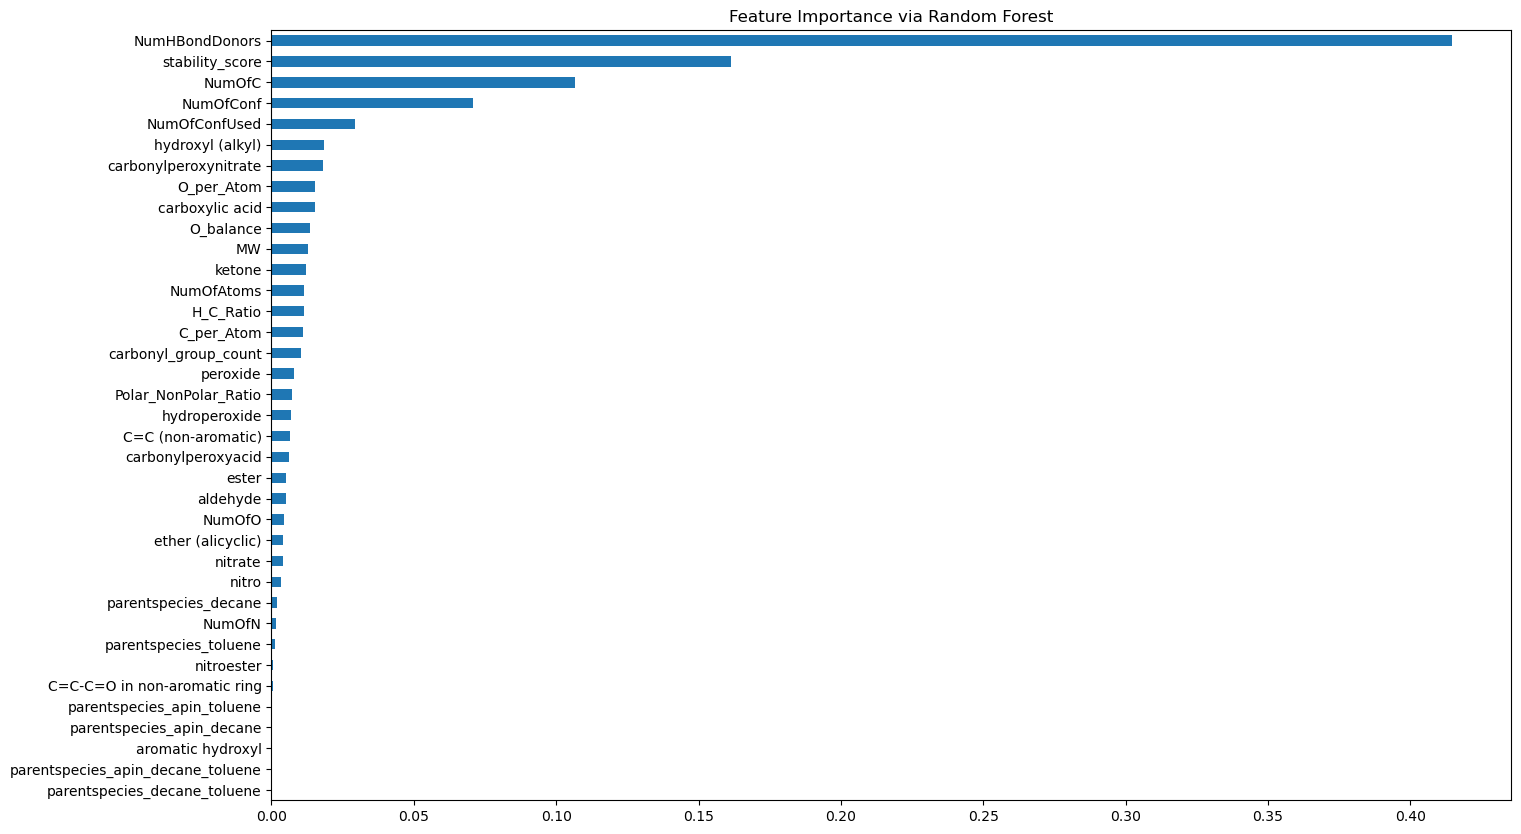

In [38]:
# similar viz for rf feature importances
plt.figure(figsize=(16, 10))
feature_importances.sort_values(ascending=True).plot.barh()
plt.title("Feature Importance via Random Forest")
plt.show()

In [19]:
# Recursive Feature Elimination with RF model
rfe_selector = RFE(estimator=model, n_features_to_select=10, step=1)
rfe_selector.fit(X, y)
selected_ft = X.columns[rfe_selector.support_]
print("\nSelected Features via RFE:\n", selected_ft)



Selected Features via RFE:
 Index(['MW', 'NumOfC', 'NumHBondDonors', 'NumOfConf', 'NumOfConfUsed',
       'hydroxyl (alkyl)', 'C_per_Atom', 'O_per_Atom', 'O_balance',
       'stability_score'],
      dtype='object')


## TESTING AREA
    - Actually anything but the feature eng part is used here , we pass all features to regressor here
    - Lin reg might not benefit this but trees can handle it and select the features themselves

In [ ]:
# Build LIGHTGBM model, XGBoost, RF, linear regression and compare train score , R2, RMSE
# use cv if its beneficial


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

models = {
    'LightGBM': LGBMRegressor(),
    'XGBoost': XGBRegressor(),
    'RandomForest': RandomForestRegressor(),
    'LinearRegression': LinearRegression()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Model:")
    print("Train Score:", model.score(X_train, y_train))
    print("R2 Score:", r2_score(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1402
[LightGBM] [Info] Number of data points in the train set: 21309, number of used features: 34
[LightGBM] [Info] Start training from score -5.513433

LightGBM Model:
Train Score: 0.7907765367717308
R2 Score: 0.742929265956113
RMSE: 1.5769933124861897

XGBoost Model:
Train Score: 0.8577955718010812
R2 Score: 0.7292629569057817
RMSE: 1.6183683389427852

RandomForest Model:
Train Score: 0.9599616512861612
R2 Score: 0.7156386489390747
RMSE: 1.6585891395871493

LinearRegression Model:
Train Score: 0.7151164361492516
R2 Score: 0.7049746571050568
RMSE: 1.689402741906329


In [ ]:
# Hyperparameter tuning for best model LGMB :)
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

lgbm = LGBMRegressor()
grid = GridSearchCV(lgbm, params, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("\nBest Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)
print("Test Score:", grid.score(X_test, y_test))

best_params = grid.best_params_
best_model = LGBMRegressor(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print("\nBest Model (LightGBM) with Tuned Parameters:")
print("Train Score:", best_model.score(X_train, y_train))
print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1398
[LightGBM] [Info] Number of data points in the train set: 17047, number of used features: 34
[LightGBM] [Info] Start training from score -5.515328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

# Why not test this with test data

In [ ]:
test_data = pd.read_csv('../Data/test.csv')

# test the tuned LIGHTGBM model
test_data = feature_engineering(test_data)
test_data = scaling(test_data)

# predict the test data with best params, predictions to new column TARGET
test_predictions = best_model.predict(test_data)
test_data['TARGET'] = test_predictions

# save ID, TARGET columns to csv
test_data[['ID', 'TARGET']].to_csv('lgbm_initial_test.csv', index=False)

# NOT GOOD -0.7 IN KAGGLE :DD

# STILL MESSY FILE 
    - 20.NOV.2024 , I tested some stuff and this code below is the one with the Public score: 0.7427


In [ ]:
# Lets do LGMB from beginning

import lightgbm as lgb
from sklearn.metrics import mean_squared_error

data = pd.read_csv('../Data/train.csv')
test_data = pd.read_csv('../Data/test.csv')

data = feature_engineering(data)

X = data.drop(columns=['log_pSat_Pa', 'ID', 'parentspecies'])
y = data['log_pSat_Pa']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
    "num_leaves": 31,
    "learning_rate": 0.20,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 0,
}

# train
gbm = lgb.train(
    params, lgb_train, num_boost_round=50, valid_sets=lgb_eval, callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f"The RMSE of prediction is: {rmse_test}")
print(f'R2 Score: {r2_score(y_test, y_pred)}')


## Predict test data
test_data = feature_engineering(test_data)
test_data2 = test_data.drop(columns=['ID','parentspecies'])
test_predictions = gbm.predict(test_data2, num_iteration=gbm.best_iteration)

test_data['TARGET'] = test_predictions

write_csv = test_data[['ID', 'TARGET']]
write_csv.to_csv('lgbm_initial_test2.csv', index=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[41]	valid_0's l2: 2.57214	valid_0's l1: 1.18337
The RMSE of prediction is: 1.603789181699059
R2 Score: 0.734118883603759
